# Bikeshare Reloaded
Adi and Xander

## Overview
In this project, we seek to build a model for New York City's Citibike bikeshare system. The primary difference between this system and the simplified bikeshare model we considered in class is the number of interconnected stations. In addition, Citibike provides a large quantity of data on its network activity, allowing us to collect statistics on individual rides and thereby build a progressively more detailed model.

## Question
### How should a fixed number of additional bikes be distributed between Citibike's NYC stations in order to reduce the number of times a potential user is unable to find a bicycle at a station?

Answering this question is important because it relates closely to Citibike's overall success as a bikeshare. In general, bike shares are valuable because they relieve congestion in roads while making it easier for users to rely on public transportation for their commutes. However, this functionality breaks down if users can't rely on a bike being available at their station of choice when they need to get to work. By analyzing a model of the bikeshare system, we might be able to explore how the addition of new bikes to stations affects the overall system dynamics, and allow hypothetical Citibike managers to make informed and cost-effective decisions for how to distribute resources.

## Model

Our model consists of a number of stations and a number of bicycles in transit between them. We decided early in the project that we wanted to leverage the very complete ride dataset compiled by Citibike, so our model focuses on including interesting characteristics we can pull out of the data. In our model,
Each station has:
- A number of bikes at the station
- The probability a new user will arrive at a station (potentially a function of time)
- The probabilities that that user will bike to each other existing station
- The speed at which that user travels
- A location in NYC
In addition, the overall system considers:
- The bicycles currently in transit: what their destination is, in how many minutes they will reach that destination

We made a few significant assumptions:
- No active effort is made to 'rebalance' the bikeshare after the simulation begins
- Bike usage doesn't change significantly across days of the week

One other important part of our model is the fact we attempt to consider not just average values for our system but also variance of those values as much as possible. Bike racks will empty more when there is more variation present in the system, because occasionally a number of random factors may stack up to empty stations of bikes. The more parameters (such as new user arrival rate and biker speed) are considered as distributions instead of constant values, the more the system's variance will match the fluctuations present in the real world.

With that said, let's jump in to the code



In [1]:
import numpy as np
from modsim import *
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import stationdefs

## Station definition

First, we define a station object which will help keep track of a number of variables. Each station has a unique identifier (using the same id system as that found in the Citibike dataset), a function which takes the current system state and returns an arrival rate of customers at the station, and a set of probabilites giving the odds a user from that station will bike to each other station in the simulation (by station id). In addition, we build functions that use these parameters to give the randomly sampled destination of a user leaving the station as well as the speed at which that user travels.

In [2]:
class Station():
    def __init__(self, station_id, arrival_rate_func, dest_probs, speed_func, latitude, longitude):
        self.station_id = station_id # Identification number of the station
        #
        self.arrival_rate_func = arrival_rate_func # Function of *time* returning the rate of user arrival in arrivals/minute
        #
        # The following attributes are constants right now but could be changed to functions of state in the future
        prob_adjust = sum([dest_probs[x] for x in dest_probs.keys()])
        self.dest_probs = dest_probs # Dict of station ids to probability a user is going to this station
        for x in dest_probs.keys():
            self.dest_probs[x] /= prob_adjust
        self.speed_func = speed_func # Average speed of a user leaving the station in miles/minute
        self.latlong = (latitude, longitude) # Position of the station
    def num_arrivals(self, state):
        # Returns the number of new user arrivals in a certain minute, calculated using a poisson distribution on the arrival rate
        arrival_rate = self.arrival_rate_func(state.time % 1440)
        return np.random.poisson(arrival_rate)
    def user_dest(self, state):
        # Samples from dest_probs and returns the station id a user is going to
        # The choice is weighted by the probability stored in dest_probs
        ids = list(self.dest_probs.keys())
        return np.random.choice(ids, p=[self.dest_probs[i] for i in ids])
    def user_speed(self, state):
        # Returns the speed of a user leaving this station
        return self.speed

## System Definition
Next, we construct a Bikeshare object, which stores the stations as well as the overall system parameters. It provides dictionaries for looking up station ids as well as functions for finding the distance between stations and stepping the state forwards. The state variables, all of the values that change significantly over the course of a run, are stored in Bikeshare.state, a State instance using the ModSimPy library. This state includes the time, the count of bikes at each station, a queue dataframe with each instance representing all the bikes in transit, and three metric variables.

At other points in the class definition, we have a station_distance() function that calculates distances between stations based on lat and long values, a step function that (increments time, adds to and subtracts from the queue dataframe and each station in the bikeshare, and calculates distances, numbers of customers arriving, times, and probabilites), a run_simulation() function that actually runs the simulation, and a data_visualization function that performs plotting of key metrics via matplotlib.

In [3]:
class Bikeshare():
    def __init__(self, stations, initial_bikes, start_time, minutes):
        # stations is an iterable holding the Station objects that make up the bikeshare.
        # self.stations is a tuple to prevent accidental item reassignment after __init__
        # initial_bikes is a dictionary from station ids to bike counts
        # start_time is the time in minutes counting from midnight that the simulation starts at.
        self.stations = tuple(stations)
        # station_lookup is a dictionary from station ids to indices of self.stations
        self.station_lookup = {}
        for i in range(len(self.stations)):
            self.station_lookup[self.stations[i].station_id] = i
        # self.state holds the various instantaneous state variables - for now these are:
        #    - time in minutes
        #    - the rider queue
        #    - the number of bikes in each station
        #    - the number of times a customer has arrived at an empty station
        self.state = State(time=start_time, queue = pd.DataFrame(columns=['dest_id', 'time_to_dest']),
                           bikes = initial_bikes, empty_count = 0, empty_times = [], stations_over_time = [])
        
        #  empty_times_s = pd.Series(data=np.zeros_like(np.arange(minutes+1)))
        # 
        self.netbikes = 0
        self.sentout = 0
        self.indices_dropped = []
    def station_distance(self, station1_id, station2_id):
        # Takes the ids of two stations and returns the distance in miles between them.
        # It is assumed that on the gridlike roads of NYC travel is only possible due east and west,
        #     meaning that this value is *not* the hypotenuse but rather the distance EW plus the 
        #     distance NS. This simplifies the calculations.
        lat_conv = 69 # Approximate number of miles to a degree of latitude
        long_conv = 53 # Approximate number of miles to a degree of longitude at NYC's latitude
        #
        station1 = self.stations[self.station_lookup[station1_id]]
        station2 = self.stations[self.station_lookup[station2_id]]
        #
        ns_dist = lat_conv * abs(station1.latlong[0] - station2.latlong[0])
        ew_dist = long_conv * abs(station1.latlong[1] - station2.latlong[1])
        #
        return ns_dist + ew_dist
    def step(self):
        # Increments the time by a minute. Processes the queue, processes new users.
        self.state.time += 1
        self.state.queue['time_to_dest'] -= 1
        self.state.stations_over_time.append(tuple(self.state.bikes.values()))
        
        # OPTIMIZE FOR C
        # run through, find values where df[time]<0
        self.indices_dropped = self.state.queue.query('time_to_dest <= 0').index#.tolist() #list of indices
        for i in self.indices_dropped :
            dest_found = int(self.state.queue.loc[i, 'dest_id'])
            self.state.bikes[dest_found] += 1
            self.netbikes += 1
        self.state.queue = self.state.queue[self.state.queue['time_to_dest']>0] #this has no negative times #filtered

        for station in stations :
            new_arrivals = station.num_arrivals(self.state)
            # For each new arrival, find where the user is going (sampled randomly).
            #    The time to their destination is found using the distance to that station
            #    and the speed of the user out of the station (constant for now).
            for i in range(new_arrivals):
                if self.state.bikes[station.station_id] > 0:
                    dest = station.user_dest(self.state)
                    t = self.station_distance(station.station_id, dest) / float(station.speed_func())
                    # print(f"Destination: {dest}, t: {t} ")
                    self.state.queue.loc[self.sentout] = [dest, t]
                    # print("Queue: \n", self.state.queue)
                    self.state.bikes[station.station_id] -= 1
                    self.netbikes -= 1
                    self.sentout += 1
                    # self.state.empty_times_s[self.state.time] = self.state.empty_times_s[self.state.time-1] 
                else:
                    self.state.empty_count += 1
                    self.state.empty_times.append((self.state.time, self.state.empty_count))
                    # self.state.empty_times_s[self.state.time] = self.state.empty_count
        
    
    def run_simulation(self):
        # print(self.state.queue.columns.tolist())
        #print('this is the bike distribution before the simulation runs')
        #print(self.state.bikes)
        for i in range(minutes):
            self.step()
            # Log any additional metrics which might be useful
        #print('\n\n \t simulation finished. \n')
        #print('this the current list of bikes in transit (queue dataframe) \n')
        #display(self.state.queue)
        #print('this is the current number of bikes at each station \n')
        #print(self.state.bikes)
        return self.state.empty_count
                                                  
    def visualize_data(self):
        # disatisfied customers plotted over time
        print('useful/interesting analytics. ')
        print('This is the total number of bikes sent out: ', self.sentout)
        try:
            times, counts = zip(*self.state.empty_times)
            plot_empty = True
        except ValueError :
            plot_empty = False
        
        if plot_empty :
            plt.plot(times, counts)
            plt.xlabel('time')
            plt.title('disatisfied customers plotted over time')
            plt.ylabel('num empty')
            plt.show()
        
        # bike values of stations over time
        plt.figure(figsize=(9, 15))
        time = np.arange(minutes)
        for temp in zip(*self.state.stations_over_time):
            plot(time, temp)
        plt.title('bike values of stations plotted over time')
        plt.legend(list(map(str, self.state.bikes.keys())))
        plt.xlabel('time')
        plt.ylabel('bikes at the station ')
        # plt.legend()
        plt.show()

Using the data collected from Citibike, we were able to hand tune the following function arr_rate, which gives the arrival rate at an average station for a given minute. The rate is modeled as following three normal distributions: a peak in the morning, a peak in the evening, and a duller peak (wider distribution) of afternoon users.

In [4]:
dist1 = lambda x: 5 * stats.norm.pdf(x, 520, 50)
dist2 = lambda x: 5 * stats.norm.pdf(x, 1075, 70)
dist3 = lambda x: 22 * stats.norm.pdf(x, 900, 300)
#arr_rate = lambda x: dist1(x % 1440) + dist2(x % 1440) + dist3(x % 1440)
arr_rate = lambda x: 5 * stats.norm.pdf(x, 520, 50) + 5 * stats.norm.pdf(x, 1075, 70) + 22 * stats.norm.pdf(x, 900, 300)

This function might seem a little ad hoc, but it makes some intuitive sense and fits the data quite well. Here's a plot of modeled arrival rate over the course of a day: it matches the data defined arrival rate over the course of a day quite well. 

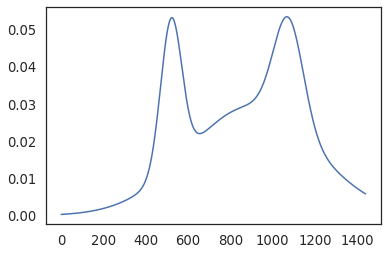

In [5]:
minutes = np.array(range(1440))
plt.plot(minutes, arr_rate(minutes))

![Comparison with Data](a.png)

Quick note relating to data-accurate model building: 

Written in our data_vis.ipynb file, and included below for reference, we have a couple functions that make our job of accurate model-building a lot easier. One function, based simply on a list of (top) stations we'd like to filter for, slices the huge original dataset and filters for only the station ID's we want. We have another function that, based on the dataset output from the previous function, calculates the probabilites that a bike will travel from one station to each other station in the dataframe, and outputs those probabilites as a readable dataframe and a dict. We input the dict here in the code cell below. 

In [17]:
# these are functions for reference only; they work with the Citibike Data, and not directly with the model featured in this notebook. 

def station_df_trimmer(df_og, list_of_stations ):
    df_copied = df_og.copy()
    df_copied = df_copied[df_copied['end station id'].isin(list_stations)]
    return df_copied[df_copied['start station id'].isin(list_stations)]


def prob_finder(df, list_stations):
    prob_df = pd.DataFrame(index=list_stations, columns=list_stations)
    for i in list_stations:
        for z in list_stations:
            # finds the instances starting with i, with the 'probabilities' going to z. 
            temp_only_i = df[df['start station id']==i]
            prob_df.loc[i][z] = (temp_only_i['end station id']==z).mean() # what we just set is the probability that the bike does go to z. 
    print('starting station represented by rows, probabilities of end stations in columns')
    #
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(prob_df)
    print(repr(prob_df.to_dict(orient='index')))
    return prob_df

Next, we build a list of stations. These values are being used to test the simulation code, and roughly represent the four most popular stations in NYC. The arrival rates are inflated somewhat to produce more immediate results. This code also helps demonstrate the composition of the system in general. 

In [6]:
stations = []
speed_func = lambda: np.random.normal(0.115, 0.052) # Approximation of Citibike data - 0.115 mi/min average, 0.052 stddev

probs_4 = {519: {519: 0.05714285714285714, 435: 0.3107142857142857, 3255: 0.2392857142857143, 497: 0.39285714285714285}, 435: {519: 0.3983739837398374, 435: 0.08130081300813008, 3255: 0.34552845528455284, 497: 0.17479674796747968}, 3255: {519: 0.34057971014492755, 435: 0.2826086956521739, 3255: 0.17391304347826086, 497: 0.2028985507246377}, 497: {519: 0.37890625, 435: 0.3359375, 3255: 0.19140625, 497: 0.09375}}

locs = stationdefs.latlongs

probs = probs_4

for s_id in probs.keys():
    stations.append(Station(s_id, arr_rate, probs[s_id], speed_func, locs[s_id][0], locs[s_id][1]))

The above code block has completed the task of setting up the speed functions, probability lookups, and geographic positions needed to construct a Bikeshare and its component Stations.

## Testing
To test the bike system, we set up a single Bikeshare object, initialize it with 10 bikes at each station, and run it for approximately 2 days. Meanwhile, we set up the function run_onestation_sweep, which performs a parameter sweep on the system, which adds a range of extra bikes to one chosen station.

In [7]:
# run this codeblock before the next one to run the simulation
even_count = {x:10 for x in probs.keys()}
begin = 400 # Time in minutes past midnight. About 6:40 in the morning, this lines up roughly with when people start using the system
minutes = 2400
bikeshare = Bikeshare(stations, even_count.copy(), begin, minutes)
# 
def run_onestation_sweep(s_id, runs_per_system, bike_num, stations, initial_bikes, begin, minutes):
    added_bikes = range(bike_num)
    empties = []
    for i in added_bikes:
        temp_initial_bikes = initial_bikes.copy()
        temp_initial_bikes[s_id] += i
        bikeshare_multi = Bikeshare(stations, temp_initial_bikes, begin, minutes)
        bikeshare_multi.run_simulation()
        empties.append(bikeshare_multi.state.empty_count)
    plt.scatter(added_bikes, empties)
    plt.xlabel('Number of Bikes Added to Station')
    plt.ylabel('Average Empty Count')
    plt.title('Bikeshare Performance with Extra Bikes in Station ' + str(s_id))

Next, let's run the first bikeshare simulation we set up. It will print the number of times a user arrived at a bikeless station:

In [8]:
bikeshare.run_simulation()

13

## Results (individual tests)

Here we detail the approach we are taking to generating interpretable, relevant, and understandable results from our simulations. Our simulations can spew a LOT of metrics, and especially when running 'sweeps', or sets of simulations with incrementally increasing variables to compare the effects of our simulation's input, the results can get messy.  

### Output & Visualizations

Let's start with the output of our simulations. One of the simplest but most critical metrics about the simulation is the discrete location and movement of the bikes, before, after and throughout the simulation, and how those values change over time.   
Using the visualize_data() function, which is found in the Bikeshare class, we can clearly, visually see how certain station's counts of bikes changed over time, and how they were dependant on eachother. 

Additionally, we can also use the visualize_data() function to observe how the empty_count, or the number of dissatisfied customers (instances a person arrived at a station to find there were no bikes) increased over the course of a day.

A quick note on our functions: although our project, at least for the code demonstrated above, uses only 4 stations, we have written our visualization functions and class framework to enable systematic, scalable testing. All of our functions work with any number of stations in the simulation. 

We can visualize how the simulation progressed over time. Bike counts varied widely over the course of the simulation. Interestingly, more than one station ran out of bikes at some point, and one station that ran out once later ended up with more bicycles than when the simulation began.

useful/interesting analytics. 
This is the total number of bikes sent out:  244


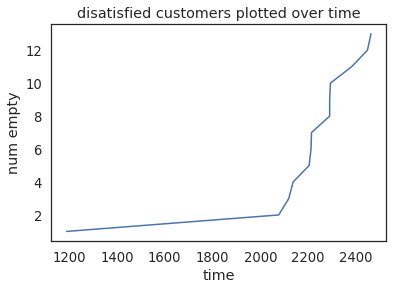

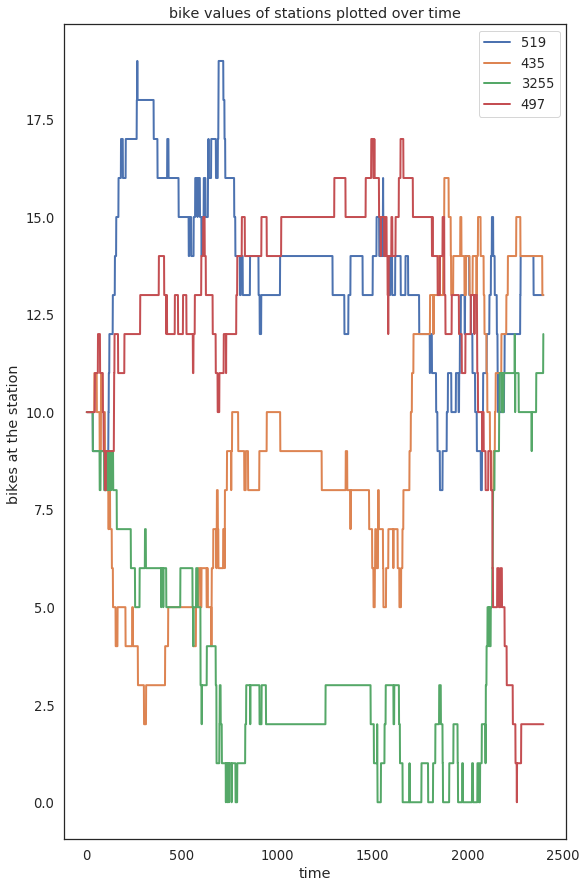

In [15]:
bikeshare.visualize_data()

## Experiment
Once the bikeshare system simulation has been tested, we performed a parameter sweep to analyze the system's behaviour. The function run_onestation_sweep changes the initial bike counts for a particular station. We ran that function on two stations, 3255 and 497, both of which ran out of bikes in our previous testing.

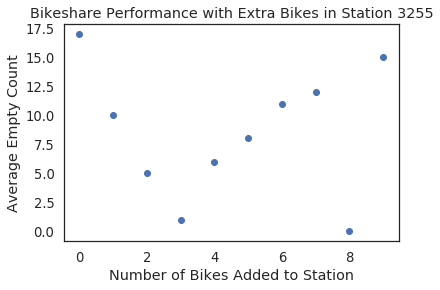

In [13]:
run_onestation_sweep(3255, 10, 10, stations, even_count.copy(), begin, minutes)

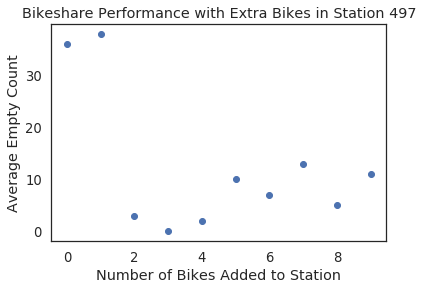

In [14]:
run_onestation_sweep(497, 10, 10, stations, even_count.copy(), begin, minutes)

## Results (sweep tests)

In both experimental runs of our model, variance is extremely high. In order to try to reduce this, 10 runs of the simulation are completed for each new set of parameters, but even with this averaging our numbers have a wide spread. In general terms, when bikes were added to station 497 the empty count dropped quickly from a high peak, but the empty counts never dropped reliably below the counts found in the sweep of station 3255.

## Interpretation

The high variability of our model makes it very difficult to draw conclusions from this test run. In the sweep of station 497, the sharp drop off looks like an encouraging result, but closer investigation raises more questions than it answers. The first runs of each sweep were performed with exactly the same initial conditions, which makes it seem very likely that the high empty counts at the beginning of 497's sweep were due to random chance. Adding bikes to 497 might create empty counts that look small, but they only appear small next to those initial outliers.

In general, to piece together useful information out of variable data it would make sense to increase the number of observations we incorporate into our averages. However, due to cocalc's somewhat limited speed 10 simulations per bike count is about at the limit of what we can reasonably wait for within the scope of this project.

Even if we don't have conclusive results about where to place bikes, out model was successful in another way. We wanted to incorporate as much of the randomness present in the world as possible in order to create the sort of natural variation we see in our everyday lives. The high variability of our simulations' results illustrate that we have succeeded at that task, and serve as a warning to others studying these sorts of systems. In the real world, observations may become even more widely distributed, and careful statistical work will be needed in order to adeptly design a bikeshare system model.


Overall, our model is very scalable, and we have a lot of data to work with. We're still fairly interested in extending this project; in the future, we may conduct more in depth testing with the variables listed below. 
- speed (represented as a function of time, rather than just a normal distribution. Bike speed can be derived from the datasets.)
- number of stations (this is one of the easiest variables to experiment with. It would be quite interesting to see how changing other variables affects the empty counts, like we are already testing with, but in the context of experimenting with the number of stations (it appears there is a potential for some 3D graphs!!))
- a probability matrix featuring functions rather than constants. (typically, we use constants to represent probabilites of station usage throughout the day. However, for a more accurate simulation, we should experiment with generating probability functions based on time, rather than simply using constants.)
- location of stations (Here, we can experiment with adding in new stations that aren't represented in the dataset. This is a great opportunity to understand how the location of certain infrastructure is modeled, optimized, and selected. However, generating the probabilites of bikes arriving to a new station not represented in the data would be challenging. We would probably would need to rely on machine learning techniques to generate the probability matrices... Adi is looking forward to this, and Xander is getting tired of Adi's shenannigans...) 